In [ ]:
import copy
import timeit
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets



In [ ]:

#Let's define MDP paras
def createGrid10World():
    def xy2s(y, x):
        # clamp to grid bounds
        x = max(0, min(x, 9))
        y = max(0, min(y, 9))
        return np.ravel_multi_index((y, x), (10, 10))  # (row, col)

    def s2xy(s):
        y, x = np.unravel_index(s, (10, 10))
        return y, x

    def gridPlot(ax, im, title='', cmap='Blues'):
        plt.imshow(im, interpolation='none', cmap=cmap, origin='lower')
        plt.colorbar()
        ax.set_xticks(np.arange(0, 10, 1))
        ax.set_yticks(np.arange(0, 10, 1))
        ax.set_xticklabels(np.arange(0, 10, 1))
        ax.set_yticklabels(np.arange(0, 10, 1))
        ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
        ax.set_yticks(np.arange(-.5, 10, 1), minor=True)
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        plt.title(title)
        return

    A = ['left', 'right', 'up', 'down']
    S = np.arange(100)
    T = np.zeros((len(S), len(A), len(S)))
    R = np.zeros((len(S), len(A)))

    for s in S:
        y, x = s2xy(s)

        # Rewards
        if (y, x) == (2, 7):
            R[s, :] = 3
        elif (y, x) == (7, 8):
            R[s, :] = 10
        else:
            if (y, x) == (7, 3):
                R[s, :] = -10
            elif (y, x) == (4, 3):
                R[s, :] = -5
            elif x == 0:  # left wall
                R[s, :] = -0.1
                R[s, 0] = -0.7
            elif x == 9:  # right wall
                R[s, :] = -0.1
                R[s, 1] = -0.7
            elif y == 0:  # bottom wall
                R[s, :] = -0.1
                R[s, 3] = -0.7
            elif y == 9:  # top wall
                R[s, :] = -0.1
                R[s, 2] = -0.7

        # Transition probabilities
        for a in A:
            if a == 'left':
                T[s, 0, xy2s(y, x - 1)] += 0.7
                T[s, 0, xy2s(y, x + 1)] += 0.1
                T[s, 0, xy2s(y - 1, x)] += 0.1
                T[s, 0, xy2s(y + 1, x)] += 0.1
            elif a == 'right':
                T[s, 1, xy2s(y, x + 1)] += 0.7
                T[s, 1, xy2s(y, x - 1)] += 0.1
                T[s, 1, xy2s(y - 1, x)] += 0.1
                T[s, 1, xy2s(y + 1, x)] += 0.1
            elif a == 'up':
                T[s, 2, xy2s(y + 1, x)] += 0.7
                T[s, 2, xy2s(y - 1, x)] += 0.1
                T[s, 2, xy2s(y, x - 1)] += 0.1
                T[s, 2, xy2s(y, x + 1)] += 0.1
            elif a == 'down':
                T[s, 3, xy2s(y - 1, x)] += 0.7
                T[s, 3, xy2s(y + 1, x)] += 0.1
                T[s, 3, xy2s(y, x - 1)] += 0.1
                T[s, 3, xy2s(y, x + 1)] += 0.1

    # Corner penalties
    for a, cx, cy in [(0,0,0), (0,0,9),(1,9,0),(1,9,9),
                      (2,0,9),(2,9,9),(3,0,0),(3,9,0)]:
        R[xy2s(cy, cx), a] = -0.8

    discount = 0.9

    # Next states dictionary
    nextStates = {}
    for si in range(len(S)):
        for ai in range(len(A)):
            nextStates[(si, ai)] = np.where(T[si, ai, :] != 0)[0]

    return {
        'S': S, 'A': A, 'T': T, 'R': R,
        'discount': discount, 'nextStates': nextStates,
        'gridPlot': gridPlot, 'xy2s': xy2s, 's2xy': s2xy
    }


In [ ]:
class MDP():
    def __init__(self):
        pass

    def inbuilt_init(self, mdp_dict):
        self.S = mdp_dict['S']
        self.A = mdp_dict['A']
        self.T = mdp_dict['T']
        self.R = mdp_dict['R']
        self.discount = mdp_dict['discount']
        self.nextStates = mdp_dict['nextStates']
        self.gridPlot = mdp_dict['gridPlot']
        self.xy2s = mdp_dict['xy2s']
        self.s2xy = mdp_dict['s2xy']

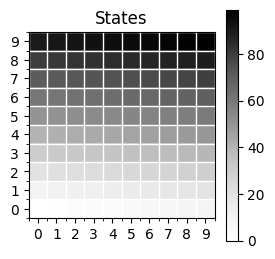

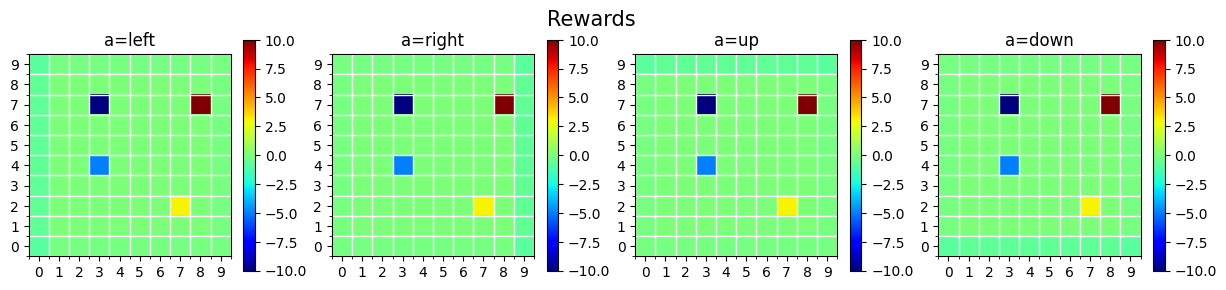

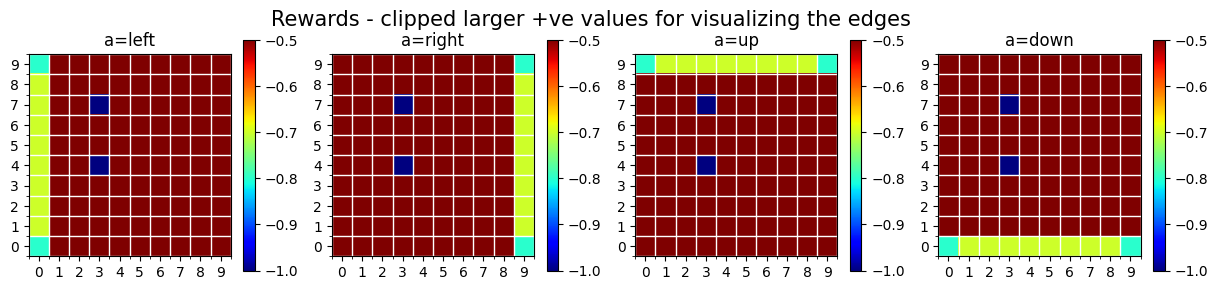

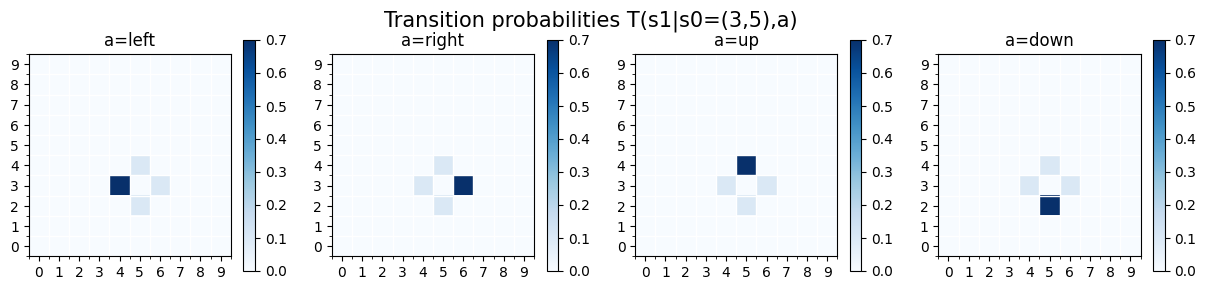

In [ ]:
#Define the MDP
mdp = MDP()
mdp.inbuilt_init(mdp_dict=createGrid10World())

#Plot states
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=mdp.S.reshape((10,10)), title='States', cmap='Greys')

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.R[:,a].reshape((10,10)), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards - clipped larger +ve values for visualizing the edges', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=np.clip(mdp.R[:,a].reshape((10,10)), -1, -0.5), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
s0_x, s0_y = 3, 5
s0 = mdp.xy2s(s0_x, s0_y)
pl.figure(figsize=(15,3))
pl.suptitle('Transition probabilities T(s1|s0=({},{}),a)'.format(s0_x, s0_y), fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title='a='+mdp.A[a], cmap='Blues')
pl.show()

In [ ]:
#An interactive plot of transition probabilities
def f(s0_x, s0_y, action):
    a = mdp.A.index(action)
    s0 = mdp.xy2s(int(s0_x), int(s0_y))
    pl.figure(figsize=(6,6))
    title = 'Transition probabilities T(s1|s0=({},{}),a={})'.format(int(s0_x),int(s0_y),action)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title=title, cmap='Blues')
    pl.show()

interactive_plot = interactive(f, s0_x='4', s0_y='5', action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']))
interactive_plot

interactive(children=(Text(value='4', description='s0_x'), Text(value='5', description='s0_y'), ToggleButtons(…

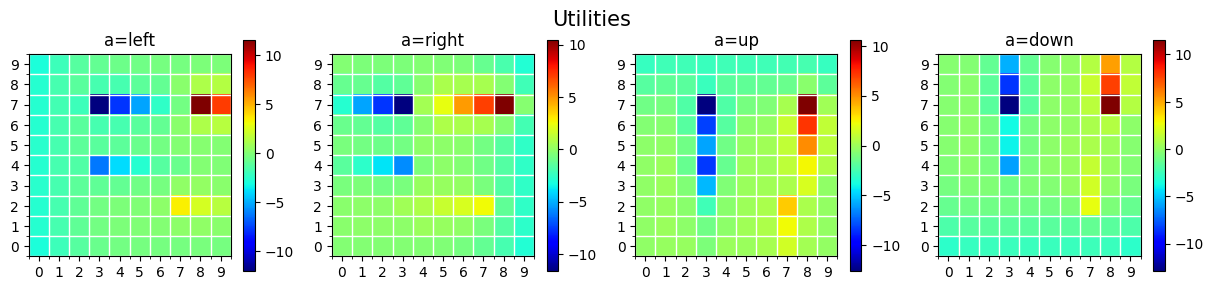

In [ ]:
def iterativePolicyEvaluation(mdp, policy, numIterations=10):
    U = np.zeros(len(mdp.S))
    for t in range(numIterations):
        U_old = copy.copy(U)
        for s in mdp.S:
            # get action for this state (single action or policy mapping)
            a = policy if isinstance(policy, int) else policy[s]

            # Bellman update
            U[s] = mdp.R[s, a] + mdp.discount * np.sum(
                mdp.T[s, a, :] * U_old
            )
    return U


numIterations = 5
pl.figure(figsize=(15,3))
pl.suptitle('Utilities', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    U = iterativePolicyEvaluation(mdp=mdp, policy=a, numIterations=numIterations)
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='a='+mdp.A[a], cmap='jet')
pl.show()
#print(np.round(U.reshape(10,10),3))

In [ ]:
def f(action, numIter=1):
    U = iterativePolicyEvaluation(mdp, policy=mdp.A.index(action), numIterations=numIter)
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    pl.show()

interactive_plot = interactive(f, action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']),
                               numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(ToggleButtons(description='action', options=('left', 'right', 'up', 'down'), value='left…

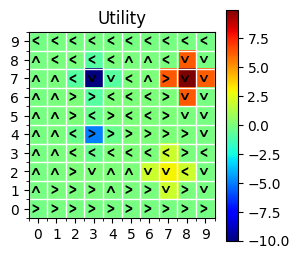

In [ ]:
#Value iteration
def valueIteration(mdp, numIterations=1):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for t in range(numIterations):
        # For each state, update utility using Bellman optimality equation
        for s in mdp.S:
            # Find the maximum Q-value over all actions
            max_q = -np.inf
            for a in range(len(mdp.A)):
                q_sa = mdp.R[s, a] + mdp.discount * np.sum(mdp.T[s, a, :] * U_old)
                if q_sa > max_q:
                    max_q = q_sa
            U[s] = max_q
        U_old = copy.copy(U)
    return U

def policyExtration(mdp, U):
    policy = np.zeros(len(mdp.S))
    # For each state, choose action that maximizes Q-value
    for s in mdp.S:
        best_a = 0
        best_val = -np.inf
        for a in range(len(mdp.A)):
            q_sa = mdp.R[s, a] + mdp.discount * np.sum(mdp.T[s, a, :] * U)
            if q_sa > best_val:
                best_val = q_sa
                best_a = a
        policy[s] = best_a
    return policy

U = valueIteration(mdp, numIterations=2)
policy = policyExtration(mdp, U=U)
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
for s in range(100):
    x, y = mdp.s2xy(s)
    if policy[s] == 0:
        m='\u02C2'
    elif policy[s] == 1:
        m='\u02C3'
    elif policy[s] == 2:
        m='\u02C4'
    elif policy[s] == 3:
        m='\u02C5'
    pl.text(x-0.5,y-1,m,color='k',size=20)
pl.show()

In [ ]:
def f(numIter=1):
    start_time = timeit.default_timer()
    U = valueIteration(mdp, numIterations=numIter)
    policy = policyExtration(mdp, U=U)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

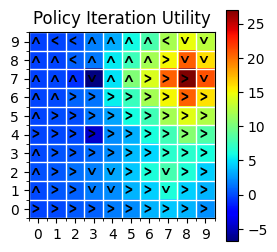

In [ ]:
import matplotlib.pyplot as plt

def policyIteration(mdp, numIterations=1):
    # Initialize utilities and policy
    U_pi_k = np.zeros(len(mdp.S))
    pi_k = np.random.randint(low=0, high=4, size=len(mdp.S), dtype=int)  # random initial policy
    pi_kp1 = copy.copy(pi_k)

    for t in range(numIterations):
        # -----------------------
        # Policy Evaluation Step
        # -----------------------
        # Iterative evaluation: update utilities based on current policy
        U_old = copy.copy(U_pi_k)
        for s in mdp.S:
            a = pi_k[s]  # action from current policy
            U_pi_k[s] = mdp.R[s, a] + mdp.discount * np.sum(mdp.T[s, a, :] * U_old)

        # -----------------------
        # Policy Improvement Step
        # -----------------------
        for s in mdp.S:
            best_a = None
            best_val = -np.inf
            for a in range(len(mdp.A)):
                q_sa = mdp.R[s, a] + mdp.discount * np.sum(mdp.T[s, a, :] * U_pi_k)
                if q_sa > best_val:
                    best_val = q_sa
                    best_a = a
            pi_kp1[s] = best_a

        # Update policy for next iteration
        pi_k = copy.copy(pi_kp1)

    return U_pi_k, pi_kp1


# -----------------------
# Run Policy Iteration
# -----------------------
U_pi_k, pi_kp1 = policyIteration(mdp, numIterations=10)

# -----------------------
# Plot Utilities + Policy
# -----------------------
plt.figure(figsize=(3,3))
mdp.gridPlot(ax=plt.gca(), im=U_pi_k.reshape(10,10), title='Policy Iteration Utility', cmap='jet')

for s in range(100):
    x, y = mdp.s2xy(s)
    if pi_kp1[s] == 0:
        m = '\u02C2'  # left
    elif pi_kp1[s] == 1:
        m = '\u02C3'  # right
    elif pi_kp1[s] == 2:
        m = '\u02C4'  # up
    elif pi_kp1[s] == 3:
        m = '\u02C5'  # down
    plt.text(x-0.5, y-1, m, color='k', size=20)

plt.show()


In [ ]:
import matplotlib.pyplot as plt

def f(numIter=1):
    start_time = timeit.default_timer()
    # code you want to evaluate
    value, policy = policyIteration(mdp, numIterations=numIter)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=value.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

 In the GridWorld notebook, increase the grid size to a large value to observe execution time
and the time to converge change

In [ ]:
def createGridWorld(size=20):
    def xy2s(y, x):
        # clamp to grid bounds
        x = max(0, min(x, size-1))
        y = max(0, min(y, size-1))
        return np.ravel_multi_index((y, x), (size, size))  # (row, col)

    def s2xy(s):
        y, x = np.unravel_index(s, (size, size))
        return y, x

    def gridPlot(ax, im, title='', cmap='Blues'):
        plt.imshow(im, interpolation='none', cmap=cmap, origin='lower')
        plt.colorbar()
        ax.set_xticks(np.arange(0, size, 1))
        ax.set_yticks(np.arange(0, size, 1))
        ax.set_xticklabels(np.arange(0, size, 1))
        ax.set_yticklabels(np.arange(0, size, 1))
        ax.set_xticks(np.arange(-.5, size, 1), minor=True)
        ax.set_yticks(np.arange(-.5, size, 1), minor=True)
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        plt.title(title)
        return
